# **Before running this notebook first run Preprocessing Data.ipynb notebook to get first 1500 questions for training and validation purpose**

# **This notebook is just simply to train model on 1500 questions and validates on validation dataset**

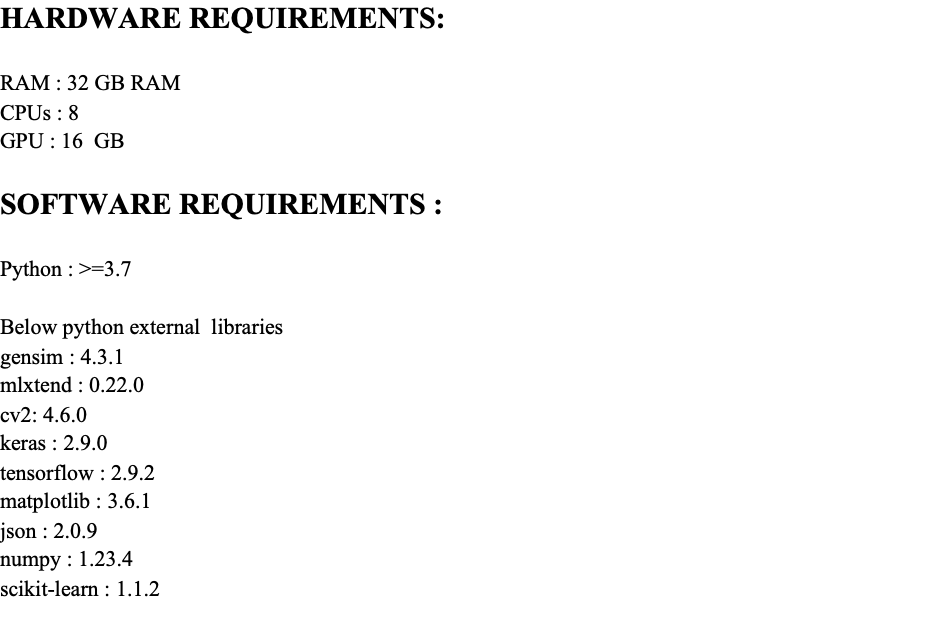

In [ ]:
pip install gensim


  Using cached smart_open-6.3.0-py3-none-any.whl (56 kB)
Note: you may need to restart the kernel to use updated packages.Successfully installed gensim-4.3.1 smart-open-6.3.0



In [ ]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


# **Google Colab**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Statements**

In [2]:
import os
import random

import cv2
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Embedding, concatenate,Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from gensim.models import Word2Vec
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import numpy as np
from collections import defaultdict
import collections
import operator
from mlxtend.preprocessing import shuffle_arrays_unison
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import load_model


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense,Attention
from tensorflow.keras.models import Model,Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Layer
from keras.layers import Bidirectional, GlobalMaxPool1D, Concatenate, Lambda
from keras.optimizers import Adam
from keras.models import Model
import keras.backend as K
import numpy as np
from keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from tensorflow.keras.layers import Dense, Concatenate



# **Load Training Data**

In [4]:
PATH='/content/drive/MyDrive/vqa/extracted_images'

In [5]:

# read the json file
annotation_file = '/content/drive/MyDrive/vqa/first_2500_annotations.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [6]:
# storing the captions and the image name in vectors
all_answers = [] # will contain all answers of all question using first_1500 ....json file
all_answers_qids = [] # will contain all question ids
all_img_name_vector = [] ##  will contain all image's paths
all_accepted_answers = [] # will contain all answers possible

for annot in annotations:

    ans_dic = collections.defaultdict(int)
    for each in annot['answers']:
        diffans = each['answer']
        if diffans in ans_dic:
            if each['answer_confidence']=='yes':
                ans_dic[diffans]+=4
            if each['answer_confidence']=='maybe':
                ans_dic[diffans]+= 2
            if each['answer_confidence']=='no':
                ans_dic[diffans]+= 1
        else:
            if each['answer_confidence']=='yes':
                ans_dic[diffans]= 4
            if each['answer_confidence']=='maybe':
                ans_dic[diffans]= 2
            if each['answer_confidence']=='no':
                ans_dic[diffans]= 1
      
    all_accepted_answers.append([' '+a[0] +' ' for a in ans_dic.items()])
    most_fav = max(ans_dic.items(), key=operator.itemgetter(1))[0]
   
    caption = ' ' + most_fav + ' ' #each['answer']
    
    image_id = annot['image_id']
    question_id = annot['question_id']
    full_coco_image_path = PATH +'/'+ 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_answers.append(caption.strip())
    all_answers_qids.append(question_id)

In [7]:
len(set(all_answers))

732

In [8]:
answers_dict=defaultdict(list)
for image_name,answer_question_id,answer in zip(all_img_name_vector,all_answers_qids,all_answers):
    answers_dict[image_name].append([answer_question_id,answer.strip()])

In [9]:
# read the json file
question_file = '/content/drive/MyDrive/vqa/corresponding_questions.json'
with open(question_file, 'r') as f:
    questions = json.load(f)

# storing the captions and the image name in vectors

question_ids =[] ##  will contain all question ids
all_questions = [] ## will contain all questions
all_img_name_vector_2 = [] # will contains full path of all images

for annot in questions:
    caption = ' ' + annot['question'] + ' '
    
    image_id = annot['image_id']
    
    full_coco_image_path = PATH +'/'+ 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
    all_img_name_vector_2.append(full_coco_image_path)
    all_questions.append(caption.strip())
    question_ids.append(annot['question_id'])

In [10]:
len(set(all_img_name_vector))

834

# **A CNN model to encode image into a feature vector**

In [11]:
#1. Image encoder

def get_image_features(img_paths):
    # Load pre-trained VGG16 model
    
    from tensorflow.keras.models import Model
    from tensorflow.keras.applications.vgg16 import VGG16
    from tensorflow.keras.applications.vgg16 import preprocess_input
    from tensorflow.keras.preprocessing import image
    import numpy as np
    base_model = VGG16(weights='imagenet')
    
    # Remove the last layer (classification layer)
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
    
    # Initialize an empty array to store the feature vectors
    features = np.zeros((len(img_paths), 128))
    
    # Loop over the image paths and encode each image
    for i, path in enumerate(img_paths):
        # Load and preprocess the input image
        img = image.load_img(path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        # Obtain the feature vector for the image
        feat = model.predict(x)
        
        # Reduce the dimensionality of the feature vector
        feat = np.squeeze(feat)
        feat = feat[:128]
        
        # Store the feature vector in the array
        features[i] = feat
    
    # Return the array of feature vectors
    return features,model

# **An LSTM with word2vec to encode each word in the question**

In [12]:
# Question encoder to get question weights and question features
def get_question_weights_and_question_features(all_questions):

# define Attention layer
    class Attention(Layer):
        def __init__(self):
            super(Attention, self).__init__()

        def build(self, input_shape):
            self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
            self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
            super(Attention, self).build(input_shape)

        def call(self, inputs):
            score = K.tanh(K.dot(inputs, self.W) + self.b)
            attention_weights = K.softmax(score, axis=1)
            context_vector = attention_weights * inputs
            context_vector = K.sum(context_vector, axis=1)

            return context_vector, attention_weights

    # function to encode a question using word2vec embeddings
    def encode_question(question,word2vec_model):
        # tokenize and pad question
        max_seq_len = 20
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts([question])
        word_index = tokenizer.word_index
        sequence = tokenizer.texts_to_sequences([question])
        padded_sequence = pad_sequences(sequence, maxlen=max_seq_len, padding='post')

        # embed each word using pre-trained word2vec weights
        vocab_size = len(word_index) + 1
        embedding_dim = 100
        embedding_matrix = np.zeros((vocab_size, embedding_dim))

        for word, i in word_index.items():
            if word in word2vec_model.wv:
                embedding_matrix[i] = word2vec_model.wv[word]
        embedding_layer = Embedding(len(word_index) + 1, embedding_dim, weights=[embedding_matrix], trainable=False)

        # encode sequence using LSTM with attention mechanism
        lstm_layer = LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)
        attention_layer = Attention()
        input_ = Input(shape=(max_seq_len,))
        embedding_layer = embedding_layer(input_)
        lstm_output = lstm_layer(embedding_layer)
        attention_output = attention_layer(lstm_output)
        model = Model(inputs=input_, outputs=attention_output)
        question_features, attention_weights = model.predict(padded_sequence)
        return question_features, attention_weights
    
    sentences=[]
    for question in all_questions:
        # split the question into a list of words and append it to the `sentences` list
        sentences.append(question.split())
    word2vec_model = Word2Vec(sentences, window=5, min_count=1, workers=4)
    
    questions =all_questions
    question_weights=[]
    question_features=[]
    for question in questions:
        question_feature, attention_weight = encode_question(question,word2vec_model)
        question_weights.append(attention_weight)
        question_features.append(question_feature)
    squeezed_arr = np.squeeze(question_features)
    question_features = np.reshape(squeezed_arr, (len(question_features), 128))
    
    
    squeezed_arr = np.squeeze(question_weights)
    question_weights = np.reshape(squeezed_arr, (len(question_weights), 20))
    return question_weights,question_features
    


# **A fusion method to integrate visual and question features together**

In [13]:
# 3. Fuse features
def fuse_features(image_features, question_features):
    # concatenate image and question features
    fused_features = Concatenate(axis=-1)([image_features, question_features])
    # apply a linear transformation
    fused_features = Dense(512, activation='relu')(fused_features)
    return np.array(fused_features)

## **Run above functions on training data**

In [14]:

question_weights,question_features=get_question_weights_and_question_features(all_questions)


1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 1s 644ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 1s 860ms/step


1/1 [==============================] - 0s 473ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 1s 880ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 1s 675ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 1s 720ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 1s 737ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 1s 740ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 1s 723ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 735ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 358ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 425ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 442ms/step


1/1 [==============================] - 0s 444ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 446ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 446ms/step


1/1 [==============================] - 0s 436ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 444ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 457ms/step


1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 1s 760ms/step


1/1 [==============================] - 0s 489ms/step


1/1 [==============================] - 0s 429ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 1s 778ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 331ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 1s 697ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 358ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 1s 745ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 327ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 350ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 1s 766ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 484ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 444ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 1s 789ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 1s 780ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 496ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 492ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 458ms/step


1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 1s 817ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 0s 452ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 429ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 1s 503ms/step


1/1 [==============================] - 0s 451ms/step


1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 335ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 462ms/step


1/1 [==============================] - 0s 452ms/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 449ms/step


1/1 [==============================] - 0s 438ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 462ms/step


1/1 [==============================] - 0s 429ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 442ms/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 1s 901ms/step


1/1 [==============================] - 0s 452ms/step


1/1 [==============================] - 0s 429ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 1s 990ms/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 429ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 351ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 436ms/step


1/1 [==============================] - 0s 442ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 434ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 0s 475ms/step


1/1 [==============================] - 0s 441ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 1s 956ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 1s 967ms/step


1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 452ms/step


1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 441ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 327ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 485ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 1s 878ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 1s 768ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 1s 780ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 1s 864ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 423ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 473ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 470ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 460ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 490ms/step


1/1 [==============================] - 0s 469ms/step


1/1 [==============================] - 0s 463ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 425ms/step


1/1 [==============================] - 0s 485ms/step


1/1 [==============================] - 0s 486ms/step


1/1 [==============================] - 0s 478ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 1s 797ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 1s 786ms/step


1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 1s 799ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 457ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 459ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 466ms/step


1/1 [==============================] - 0s 472ms/step


1/1 [==============================] - 0s 471ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 481ms/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 331ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 1s 503ms/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 484ms/step


1/1 [==============================] - 0s 494ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 357ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 743ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 1s 533ms/step


1/1 [==============================] - 1s 554ms/step


1/1 [==============================] - 1s 519ms/step


1/1 [==============================] - 1s 589ms/step


1/1 [==============================] - 1s 518ms/step


1/1 [==============================] - 0s 488ms/step


1/1 [==============================] - 1s 786ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 1s 755ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 1s 805ms/step


1/1 [==============================] - 0s 487ms/step


1/1 [==============================] - 1s 765ms/step


1/1 [==============================] - 1s 764ms/step


1/1 [==============================] - 1s 696ms/step


1/1 [==============================] - 1s 680ms/step


1/1 [==============================] - 1s 732ms/step


1/1 [==============================] - 1s 699ms/step


1/1 [==============================] - 1s 762ms/step


In [15]:
image_features,model_of_image=get_image_features(all_img_name_vector)


1/1 [==============================] - 0s 28ms/step


In [20]:
fused_matrix = fuse_features(image_features, question_features)

In [22]:
np.savez_compressed('/content/drive/MyDrive/vqa/saving_all_things', a=question_weights,b=question_features, c=image_features,d=fused_matrix)

# **GETTING SAVED FEATURES**

In [23]:
question_features=np.load("/content/drive/MyDrive/vqa/saving_all_things.npz")['b']
question_weights=np.load("/content/drive/MyDrive/vqa/saving_all_things.npz")['a']
image_features=np.load("/content/drive/MyDrive/vqa/saving_all_things.npz")['c']
fused_matrix=np.load("/content/drive/MyDrive/vqa/saving_all_things.npz")['d']

# **Train Model**

In [125]:
#4 CUSTOM MLP model to predict
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Define the MLP model
def create_mlp(num_classes, input_shape):

    model = Sequential()
    model.add(Dense(1024, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model


In [127]:

# TRAIN MLP MODEL

train_on_how_many_images=2500
# # create a dictionary mapping each unique string to a unique integer
string_to_int = {string: i for i, string in enumerate(set(all_answers))}
string_to_int["r"]=733
string_to_int["rh"]=734
string_to_int["ry"]=735
string_to_int["ri"]=736
string_to_int["ro"]=737
# convert each string in the list to its corresponding integer
all_answers_int = [string_to_int[string] for string in all_answers]

# use the to_categorical function to one-hot encode the integers
all_answers_one_hot = to_categorical(np.array(all_answers_int), num_classes=len(string_to_int))


new_fused_matrix, new_all_answers_one_hot = shuffle_arrays_unison(arrays=[fused_matrix[0:train_on_how_many_images], all_answers_one_hot[0:train_on_how_many_images]], random_seed=3)
# Create the MLP model
mlp_model = create_mlp(737, 512)

# Compile the model
mlp_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
mlp_model.fit(new_fused_matrix, new_all_answers_one_hot, validation_split=0, epochs=
          25, batch_size=16)

Epoch 1/25
157/157 [==============================] - 2s 4ms/step - loss: 5.3433 - accuracy: 0.1900
Epoch 2/25
157/157 [==============================] - 1s 4ms/step - loss: 5.2997 - accuracy: 0.1880
Epoch 3/25
157/157 [==============================] - 1s 5ms/step - loss: 5.2662 - accuracy: 0.1956
Epoch 4/25
157/157 [==============================] - 1s 5ms/step - loss: 5.1823 - accuracy: 0.1928
Epoch 5/25
157/157 [==============================] - 1s 5ms/step - loss: 4.9080 - accuracy: 0.1964
Epoch 6/25
157/157 [==============================] - 1s 5ms/step - loss: 4.5607 - accuracy: 0.1940
Epoch 7/25
157/157 [==============================] - 1s 4ms/step - loss: 4.2489 - accuracy: 0.1996
Epoch 8/25
157/157 [==============================] - 1s 4ms/step - loss: 3.9222 - accuracy: 0.2112
Epoch 9/25
157/157 [==============================] - 1s 4ms/step - loss: 3.6805 - accuracy: 0.2084
Epoch 10/25
157/157 [==============================] - 1s 4ms/step - loss: 3.4692 - accuracy: 0.1964

# **Validation part**

In [32]:

PATH='/content/drive/MyDrive/vqa/val_images'
# read the json file
annotation_file = '/content/drive/MyDrive/vqa/first_2500_val_annotations.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_answers_val = [] # will contain all answers of all question using first_1500 ....json file
all_answers_qids_val = [] # will contain all question ids
all_img_name_vector_val= [] ##  will contain all image's paths
all_accepted_answers_val = [] # will contain all answers possible

for annot in annotations:
#    print(annot)
#     break
    ans_dic = collections.defaultdict(int)
   # print("ans_dic", ans_dic)
    for each in annot['answers']:
        diffans = each['answer']
        if diffans in ans_dic:
            if each['answer_confidence']=='yes':
                ans_dic[diffans]+=4
            if each['answer_confidence']=='maybe':
                ans_dic[diffans]+= 2
            if each['answer_confidence']=='no':
                ans_dic[diffans]+= 1
        else:
            if each['answer_confidence']=='yes':
                ans_dic[diffans]= 4
            if each['answer_confidence']=='maybe':
                ans_dic[diffans]= 2
            if each['answer_confidence']=='no':
                ans_dic[diffans]= 1
      # print("after else ans_dic", ans_dic) 
      # print(ans_dic.items()) 
      # break
    all_accepted_answers_val.append([' '+a[0] +' ' for a in ans_dic.items()])
    most_fav = max(ans_dic.items(), key=operator.itemgetter(1))[0]
    #print(most_fav)
    caption = ' ' + most_fav + ' ' #each['answer']
    
    image_id = annot['image_id']
    question_id = annot['question_id']
    full_coco_image_path = PATH +'/'+ 'COCO_val2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector_val.append(full_coco_image_path)
    all_answers_val.append(caption.strip())
    all_answers_qids_val.append(question_id)

In [35]:
# read the json file
question_file = '/content/drive/MyDrive/vqa/corresponding_val_questions.json'
with open(question_file, 'r') as f:
    questions = json.load(f)
# print(questions[0])
# storing the captions and the image name in vectors

question_ids_val =[] ##  will contain all question ids
all_questions_val = [] ## will contain all questions
all_img_name_vector_2_val = [] # will contains full path of all images

for annot in questions:
    caption = ' ' + annot['question'] + ' '
    # print("caption",caption)
    
    image_id = annot['image_id']
    # v.add(image_id)
    # print("image_id",image_id)
    full_coco_image_path = PATH +'/'+ 'COCO_val2014_' + '%012d.jpg' % (image_id)
    # print(full_coco_image_path)

    all_img_name_vector_2_val.append(full_coco_image_path)
    all_questions_val.append(caption.strip())
    question_ids_val.append(annot['question_id'])

In [36]:

question_weights_val,question_features_val=get_question_weights_and_question_features(all_questions_val)


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 361ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 1s 749ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 356ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 363ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 244ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 446ms/step


1/1 [==============================] - 0s 434ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 1s 859ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 1s 852ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 445ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 1s 532ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 460ms/step


1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 415ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 434ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 471ms/step


1/1 [==============================] - 0s 452ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 435ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 245ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 1s 758ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 1s 836ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 1s 779ms/step


1/1 [==============================] - 0s 352ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 423ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 415ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 415ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 421ms/step


1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 416ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 329ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 465ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 315ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 1s 794ms/step


1/1 [==============================] - 0s 486ms/step


1/1 [==============================] - 0s 443ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 459ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 0s 463ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 455ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 351ms/step


1/1 [==============================] - 0s 358ms/step


1/1 [==============================] - 0s 441ms/step


1/1 [==============================] - 0s 434ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 419ms/step


1/1 [==============================] - 0s 431ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 352ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 442ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 433ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 1s 501ms/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 350ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 358ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 1s 814ms/step


1/1 [==============================] - 0s 355ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 1s 805ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 331ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 351ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 425ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 464ms/step


1/1 [==============================] - 0s 446ms/step


1/1 [==============================] - 0s 423ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 1s 982ms/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 409ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 1s 949ms/step


1/1 [==============================] - 0s 350ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 401ms/step


1/1 [==============================] - 0s 407ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 291ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 390ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 331ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 313ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 405ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 428ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 345ms/step


1/1 [==============================] - 0s 334ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 396ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 353ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 420ms/step


1/1 [==============================] - 0s 445ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 426ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 468ms/step


1/1 [==============================] - 0s 470ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 815ms/step


1/1 [==============================] - 0s 472ms/step


1/1 [==============================] - 0s 406ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 438ms/step


1/1 [==============================] - 0s 414ms/step


1/1 [==============================] - 0s 427ms/step


1/1 [==============================] - 0s 435ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 330ms/step


1/1 [==============================] - 0s 447ms/step


1/1 [==============================] - 0s 456ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 430ms/step


1/1 [==============================] - 0s 437ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 494ms/step


1/1 [==============================] - 0s 470ms/step


1/1 [==============================] - 0s 450ms/step


1/1 [==============================] - 0s 455ms/step


1/1 [==============================] - 0s 440ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 364ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 827ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 324ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 1s 811ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 383ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 1s 856ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 373ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 347ms/step


1/1 [==============================] - 0s 307ms/step


1/1 [==============================] - 0s 314ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 328ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 376ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 360ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 408ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 386ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 410ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 337ms/step


1/1 [==============================] - 0s 454ms/step


1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 399ms/step


1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 1s 965ms/step


1/1 [==============================] - 0s 465ms/step


1/1 [==============================] - 0s 449ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 354ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 473ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 311ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 467ms/step


1/1 [==============================] - 0s 443ms/step


1/1 [==============================] - 0s 424ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 368ms/step


1/1 [==============================] - 0s 465ms/step


1/1 [==============================] - 0s 481ms/step


1/1 [==============================] - 0s 457ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 305ms/step


1/1 [==============================] - 0s 292ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 293ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 393ms/step


1/1 [==============================] - 0s 374ms/step


1/1 [==============================] - 0s 473ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 326ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 366ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 367ms/step


1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 349ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 309ms/step


1/1 [==============================] - 0s 312ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 276ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 371ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 346ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 286ms/step


1/1 [==============================] - 0s 300ms/step


1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 394ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 380ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 274ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 340ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 362ms/step


1/1 [==============================] - 0s 385ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 388ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 288ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 1s 778ms/step


1/1 [==============================] - 0s 344ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 287ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 278ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 402ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 439ms/step


1/1 [==============================] - 0s 369ms/step


1/1 [==============================] - 0s 304ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 1s 797ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 415ms/step


1/1 [==============================] - 0s 412ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 398ms/step


1/1 [==============================] - 0s 400ms/step


1/1 [==============================] - 0s 332ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 490ms/step


1/1 [==============================] - 0s 459ms/step


1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 273ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 389ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 0s 448ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 295ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 270ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 378ms/step


1/1 [==============================] - 0s 489ms/step


1/1 [==============================] - 0s 432ms/step


1/1 [==============================] - 0s 443ms/step


1/1 [==============================] - 0s 306ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 294ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 259ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 262ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 258ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 382ms/step


1/1 [==============================] - 0s 489ms/step


1/1 [==============================] - 0s 493ms/step


1/1 [==============================] - 0s 341ms/step


1/1 [==============================] - 0s 333ms/step


1/1 [==============================] - 0s 308ms/step


1/1 [==============================] - 0s 302ms/step


1/1 [==============================] - 0s 290ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 299ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 327ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 381ms/step


1/1 [==============================] - 0s 372ms/step


1/1 [==============================] - 0s 359ms/step


1/1 [==============================] - 0s 338ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 310ms/step


1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 298ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 280ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 277ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 317ms/step


1/1 [==============================] - 0s 370ms/step


1/1 [==============================] - 0s 365ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 425ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 343ms/step


1/1 [==============================] - 0s 342ms/step


1/1 [==============================] - 0s 319ms/step


1/1 [==============================] - 0s 316ms/step


1/1 [==============================] - 0s 296ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 285ms/step


1/1 [==============================] - 0s 282ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 281ms/step


1/1 [==============================] - 0s 283ms/step


1/1 [==============================] - 0s 279ms/step


1/1 [==============================] - 0s 272ms/step


1/1 [==============================] - 0s 275ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 387ms/step


1/1 [==============================] - 0s 392ms/step


1/1 [==============================] - 0s 395ms/step


1/1 [==============================] - 0s 417ms/step


1/1 [==============================] - 0s 384ms/step


1/1 [==============================] - 0s 266ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 255ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 268ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 348ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 325ms/step


1/1 [==============================] - 0s 321ms/step


1/1 [==============================] - 0s 320ms/step


1/1 [==============================] - 0s 284ms/step


1/1 [==============================] - 0s 271ms/step


1/1 [==============================] - 0s 267ms/step


1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 375ms/step


1/1 [==============================] - 0s 379ms/step


1/1 [==============================] - 0s 403ms/step


1/1 [==============================] - 0s 391ms/step


1/1 [==============================] - 0s 377ms/step


1/1 [==============================] - 0s 257ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 252ms/step


1/1 [==============================] - 0s 253ms/step


1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 254ms/step


1/1 [==============================] - 0s 356ms/step


In [37]:
image_features_val,model_of_image_val=get_image_features(all_img_name_vector_val)


1/1 [==============================] - 0s 22ms/step


In [38]:
fused_matrix_val = fuse_features(image_features_val, question_features_val)

In [77]:
np.savez_compressed('/content/drive/MyDrive/vqa/saving_all_things_val', a=question_weights_val,b=question_features_val, c=image_features_val,d=fused_matrix_val)

In [48]:
string_to_int_val = {string: i for i, string in enumerate(set(all_answers_val))}

# convert each string in the list to its corresponding integer
all_answers_int_val = [string_to_int_val[string] for string in all_answers_val]

# use the to_categorical function to one-hot encode the integers
all_answers_one_hot_val = to_categorical(np.array(all_answers_int_val), num_classes=len(string_to_int_val))

# **30 randomly chosen examples from the validation set of VQA v1 dataset**

In [110]:
# TAKE RANDOM SAMPLES

samples_to_tbe_taken=30
random_fused_matrix=[]
random_answers_one_hot=[]
random_question_features=[]
random_question_weights=[]
random_image_features=[]
random_questions=[]
random_answers=[]
random_image_paths=[]
for i in range(samples_to_tbe_taken):
    x=random.randint(400,600)
    random_fused_matrix.append(fused_matrix_val[x])
    random_answers_one_hot.append(all_answers_one_hot_val[x])
    random_question_features.append(question_features_val[x])
    random_question_weights.append(question_weights_val[x])
    random_image_features.append(image_features_val[x])
    random_questions.append(all_questions_val[x])
    random_answers.append(all_answers_val[x])
    random_image_paths.append(all_img_name_vector_val[x])

    
random_answers_one_hot=np.array(random_answers_one_hot)
random_fused_matrix=np.array(random_fused_matrix)
random_question_features=np.array(random_question_features)
random_question_weights=np.array(random_question_weights)
random_image_features=np.array(random_image_features)


In [128]:
# CALCULATING ACCURACY FOR RANDOM SAMPLES
random_accuracy=mlp_model.evaluate(random_fused_matrix,random_answers_one_hot)
predicted_answers_one_hot=mlp_model.predict(random_fused_matrix)

1/1 [==============================] - 0s 52ms/step


In [129]:
indexes_true_answers=[]
for arr in random_answers_one_hot:
    indexes_true_answers.append(np.argmax(arr))
indexs_predicted_answers=[]
for arr in predicted_answers_one_hot:
    indexs_predicted_answers.append(np.argmax(arr))

predicted_answers=[]
for index in indexs_predicted_answers:
    predicted_answers.append(all_answers_val[index]) 

In [130]:
acc=0
for i in range(len(random_image_paths)): 
    if random_answers[i]==predicted_answers[i]:
        acc+=1   
    img_path =random_image_paths[i]
    print("Question is ",random_questions[i])
    print("Actual answer is ",random_answers[i])
    print("Predicted answer is ",predicted_answers[i])
    image = plt.imread(img_path)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    print()

print("ACCURACY IS " ,(acc/len(indexes_true_answers))*100,"%")

Output hidden; open in https://colab.research.google.com to view.

# **The attention map between the answer and words in the question**

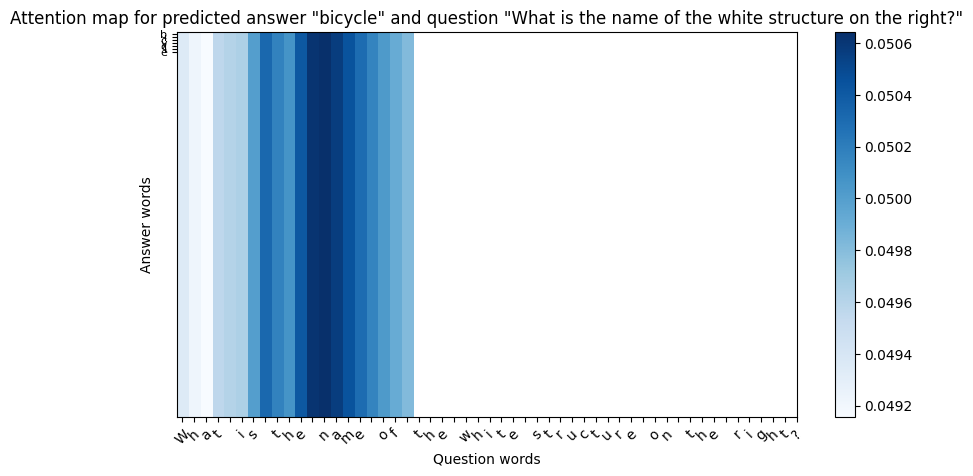

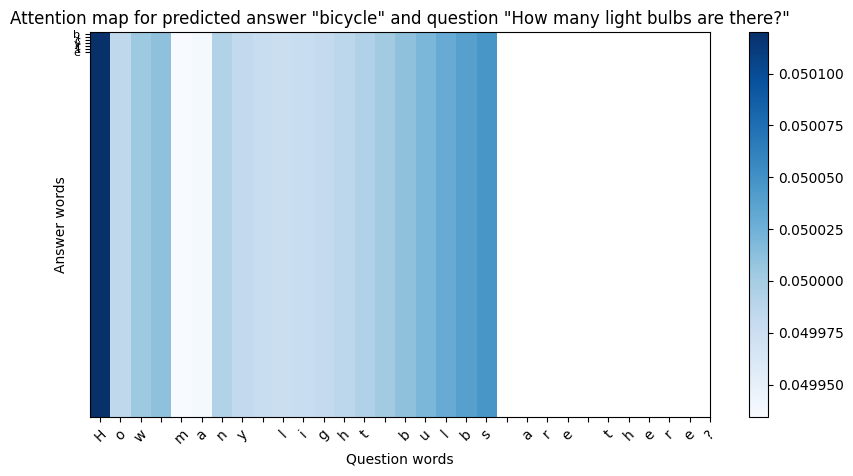

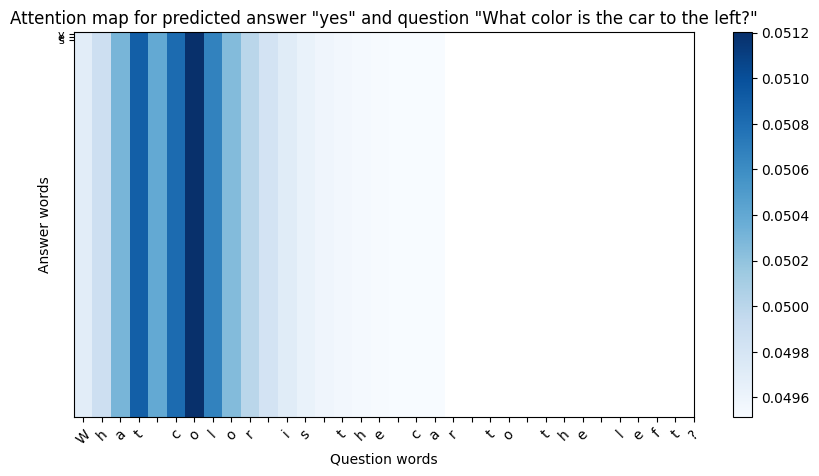

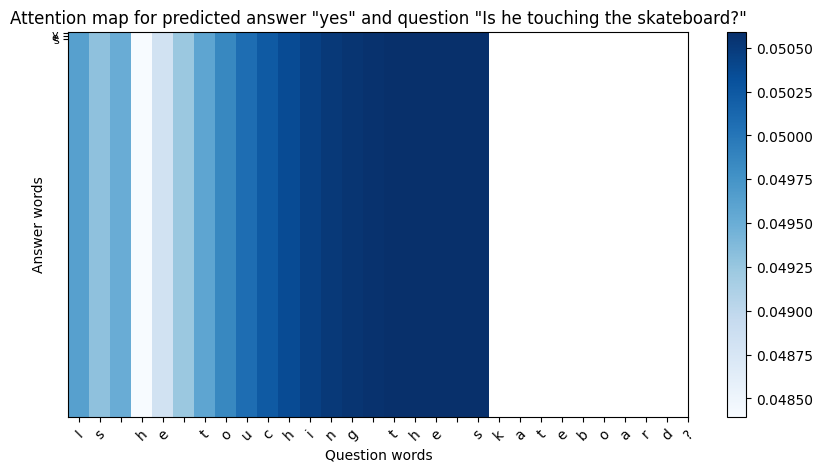

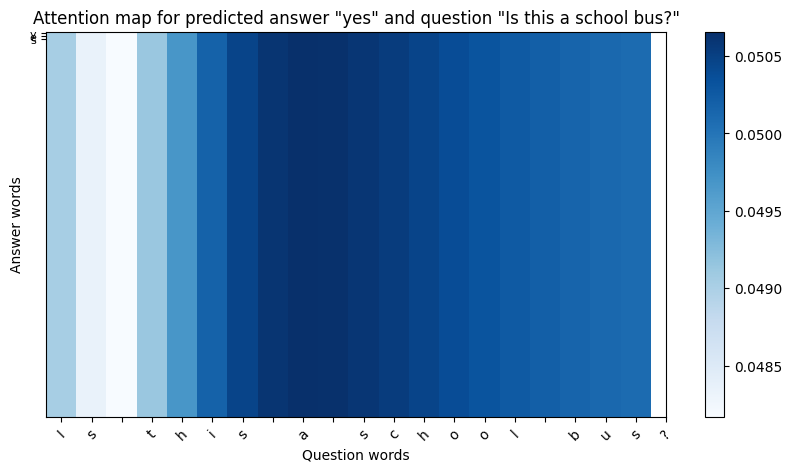

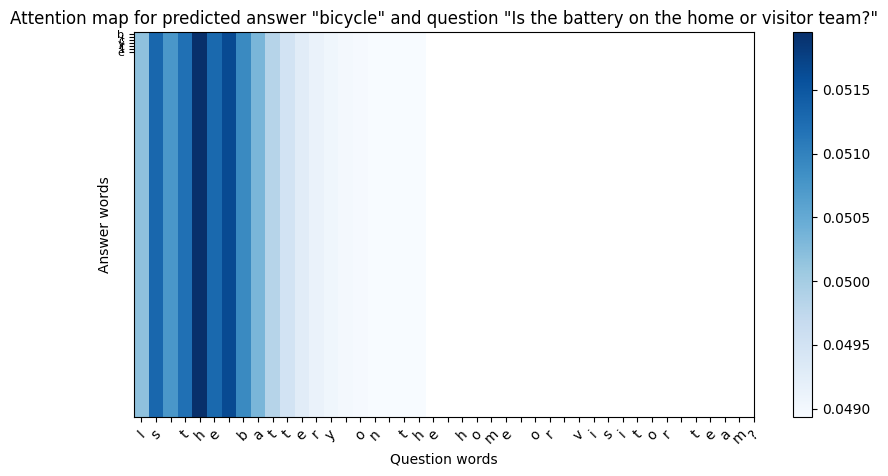

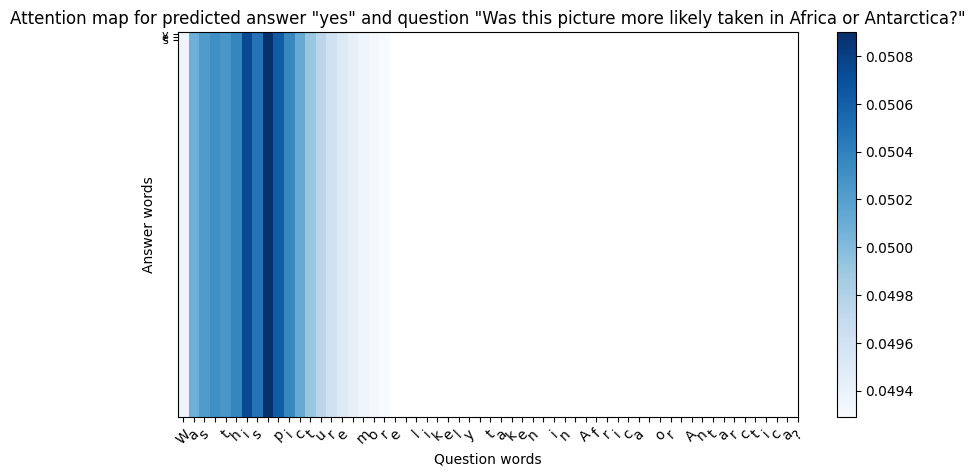

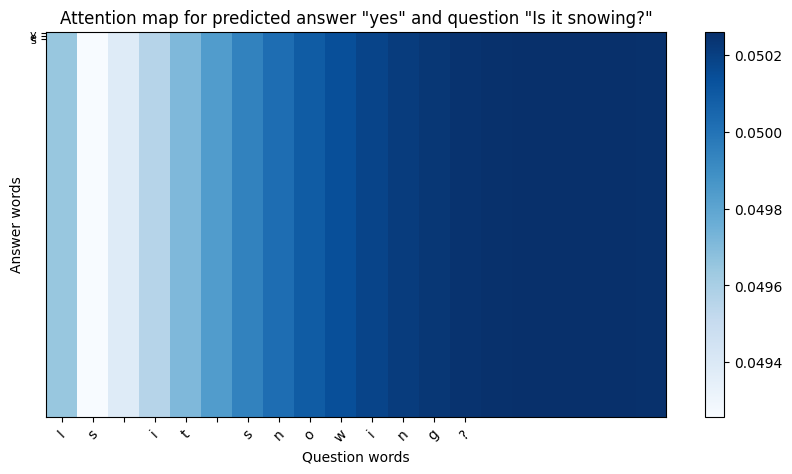

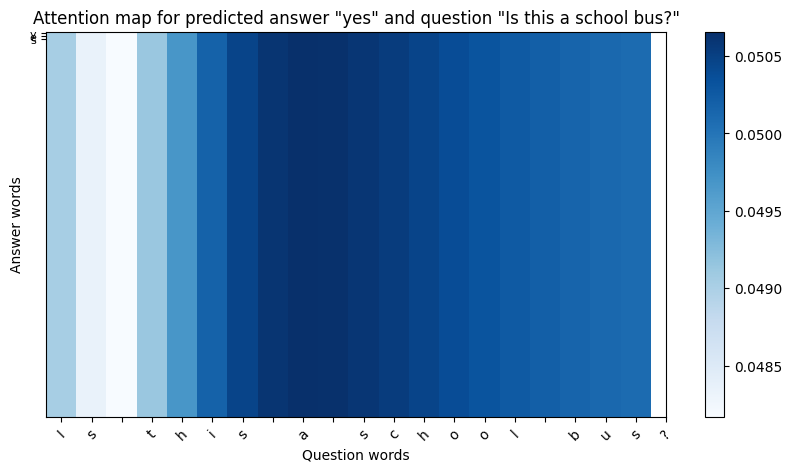

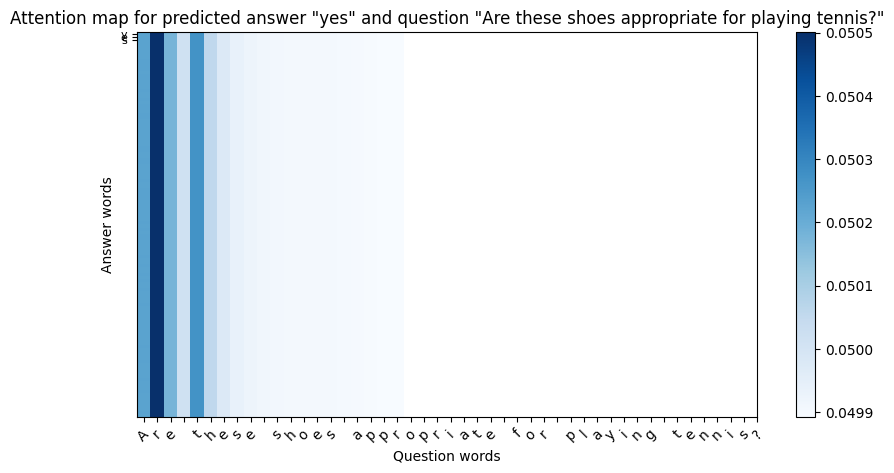

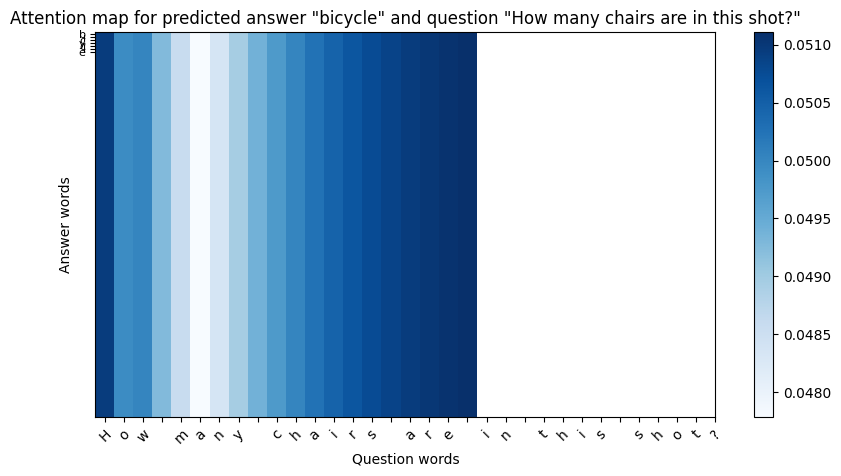

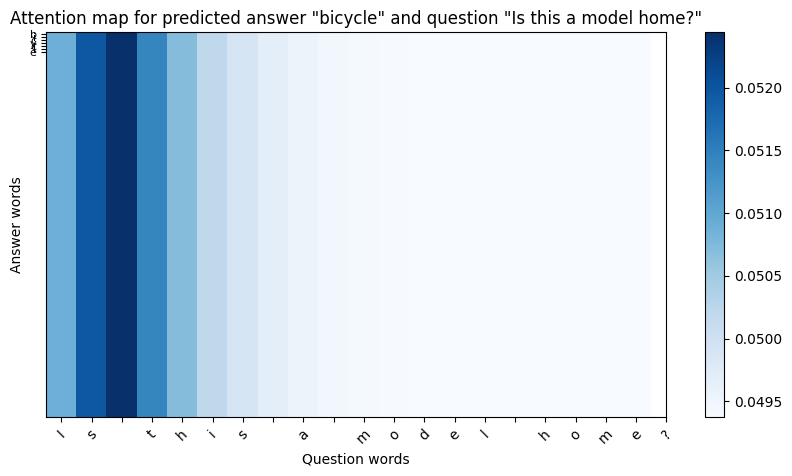

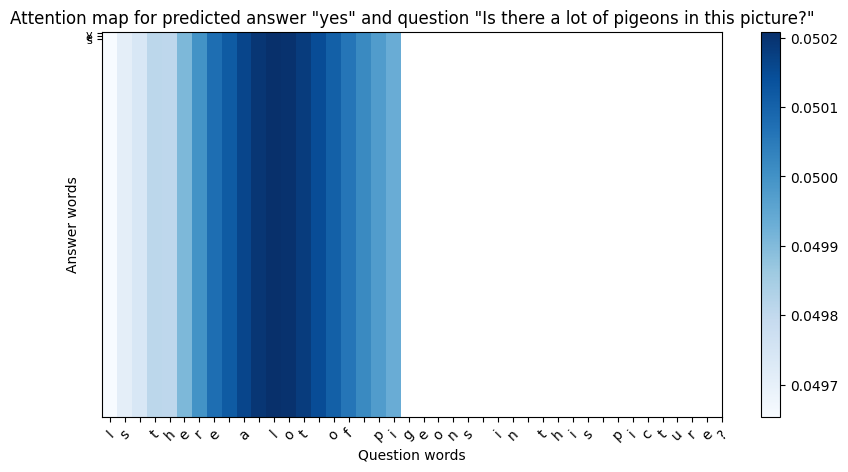

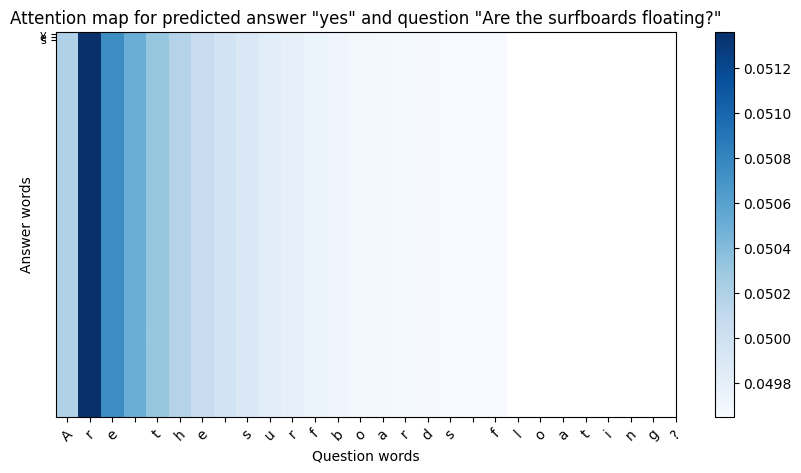

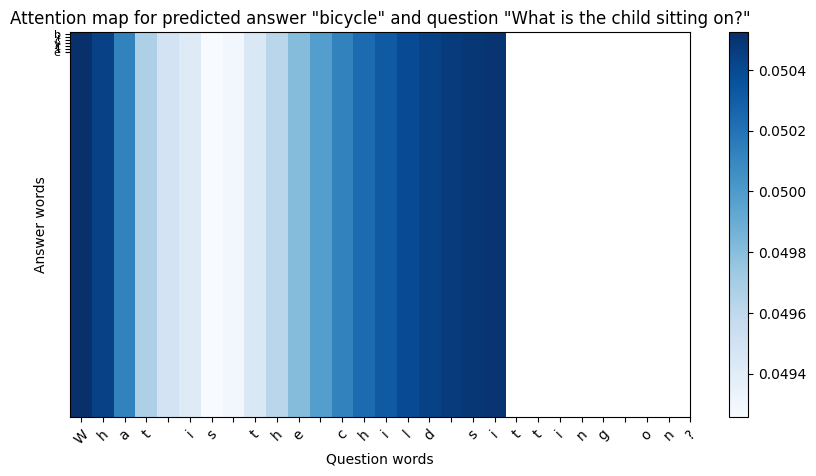

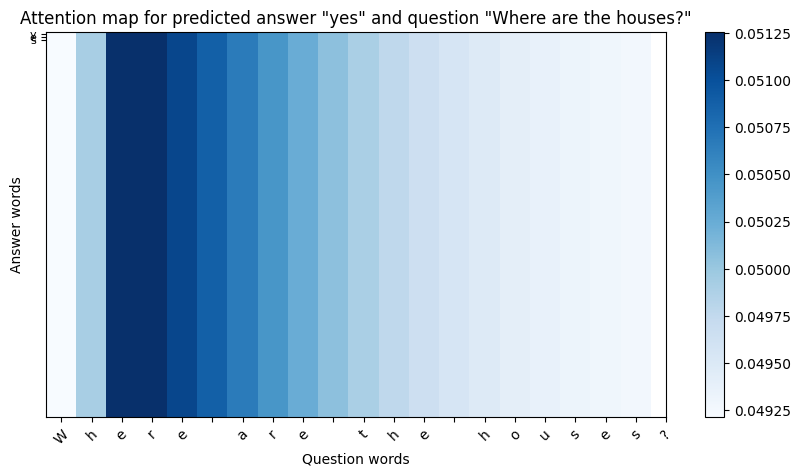

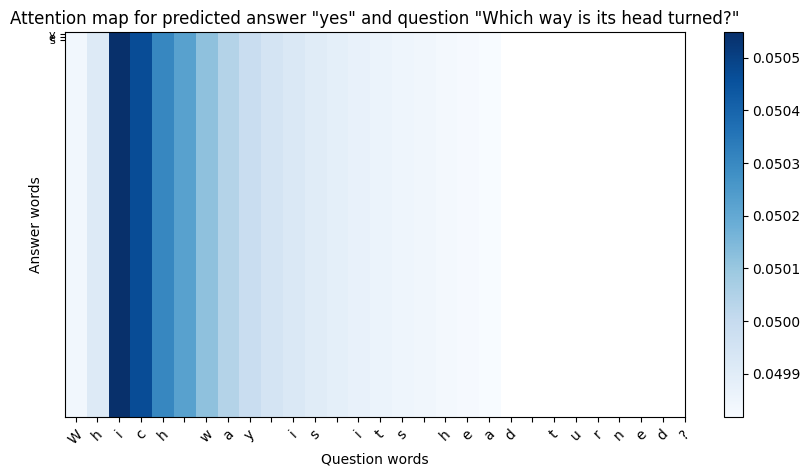

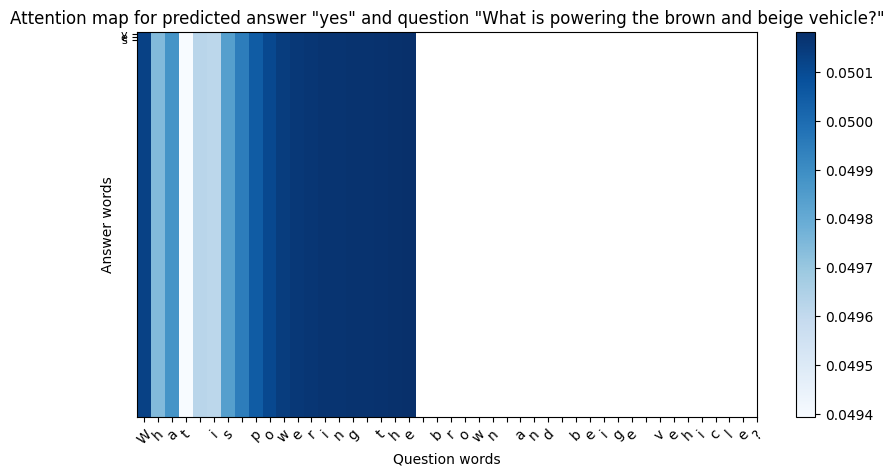

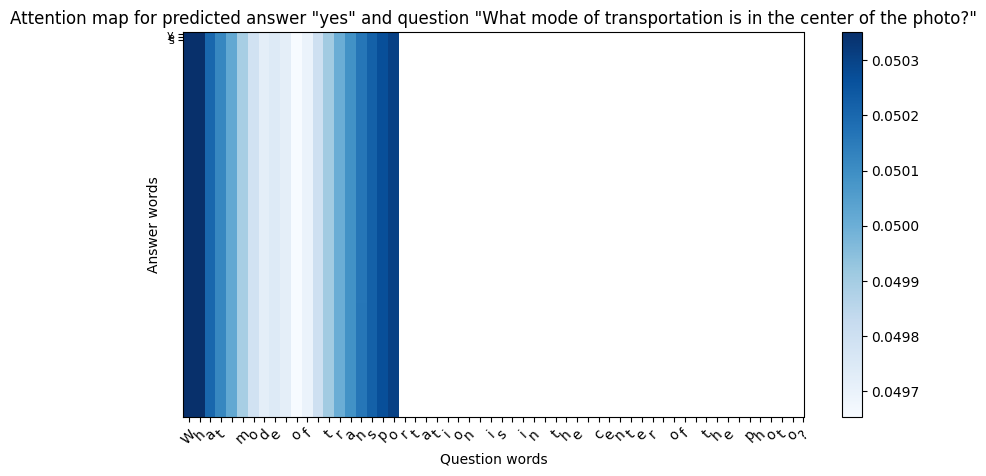

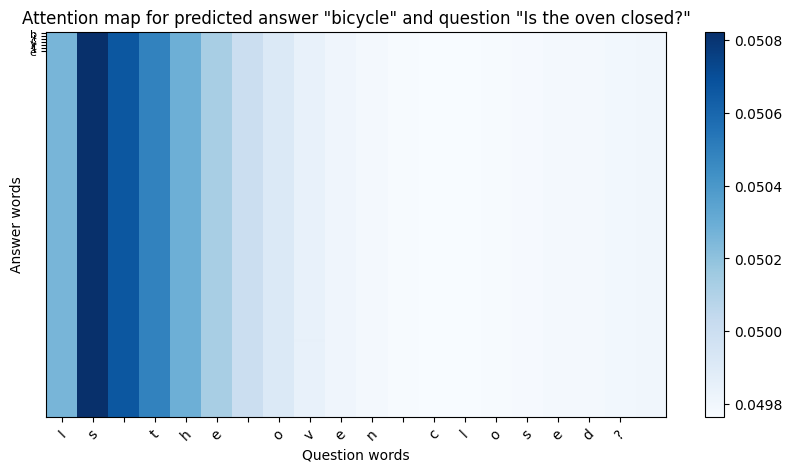

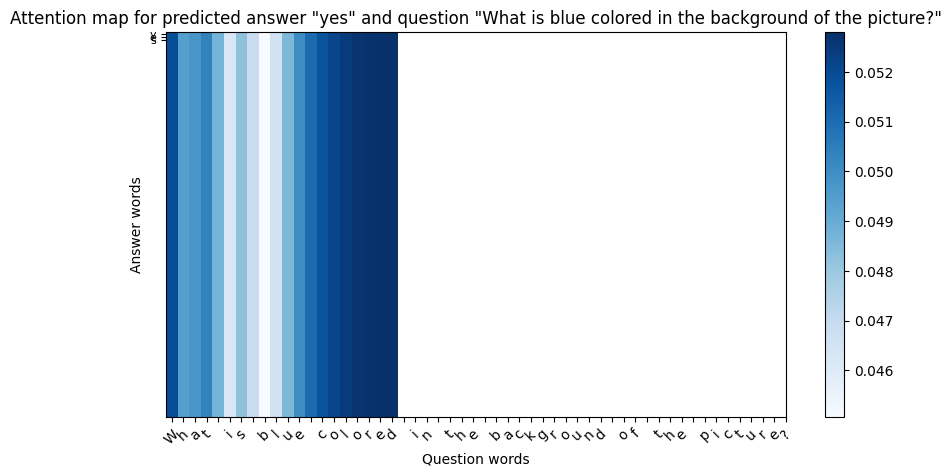

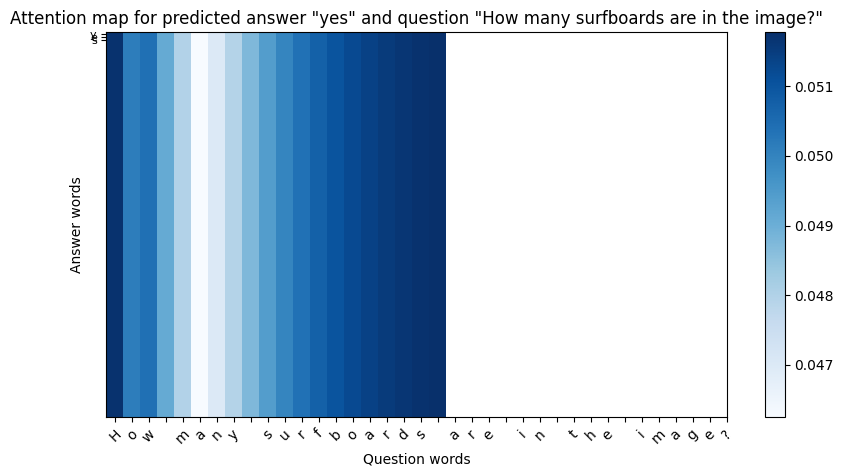

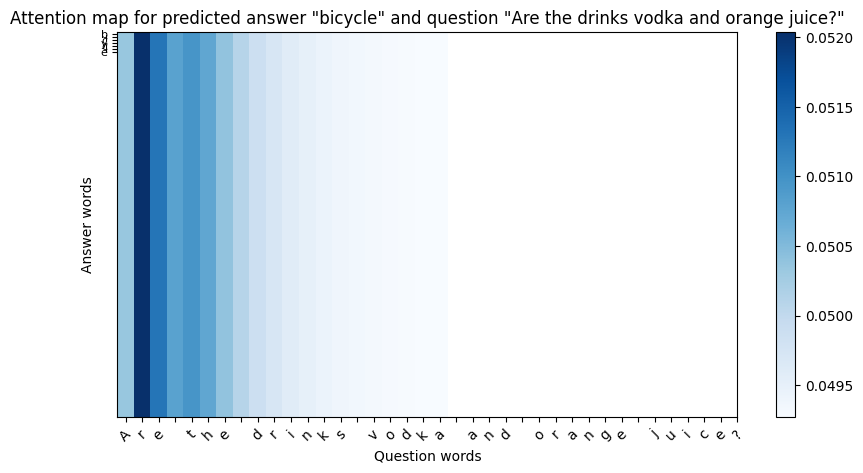

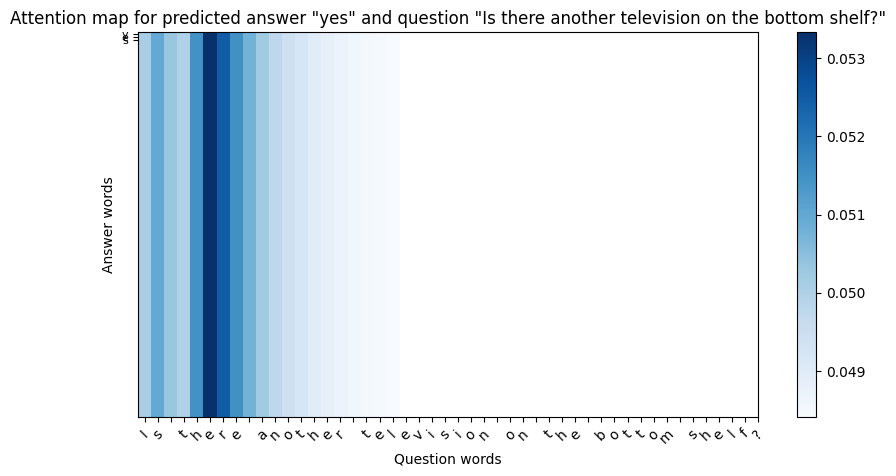

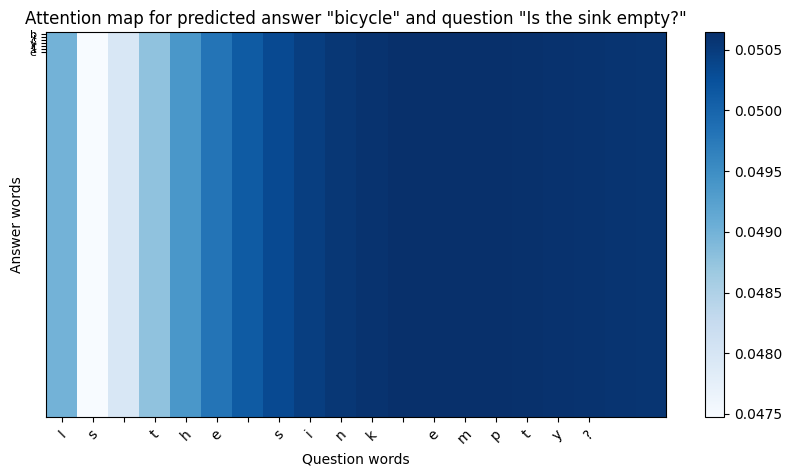

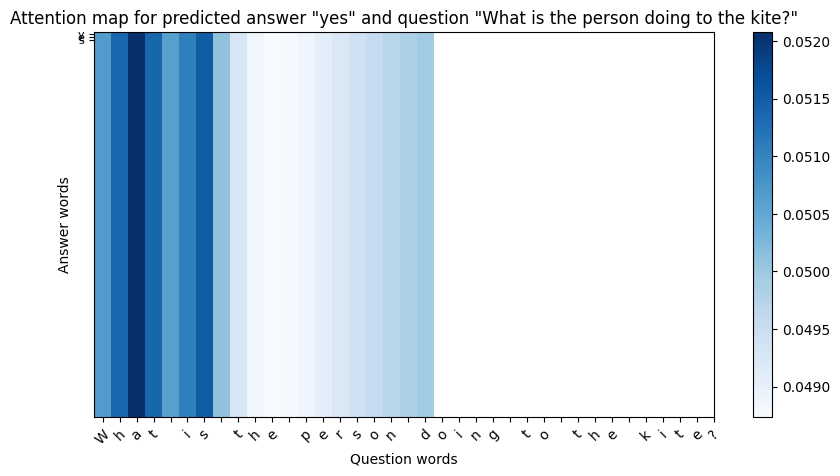

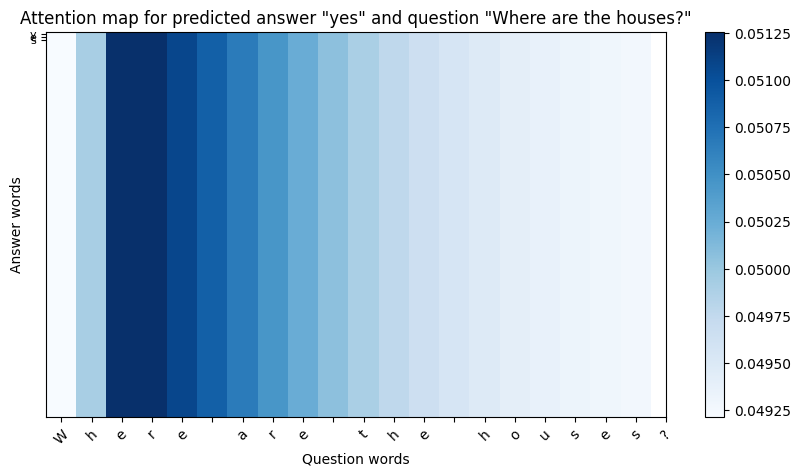

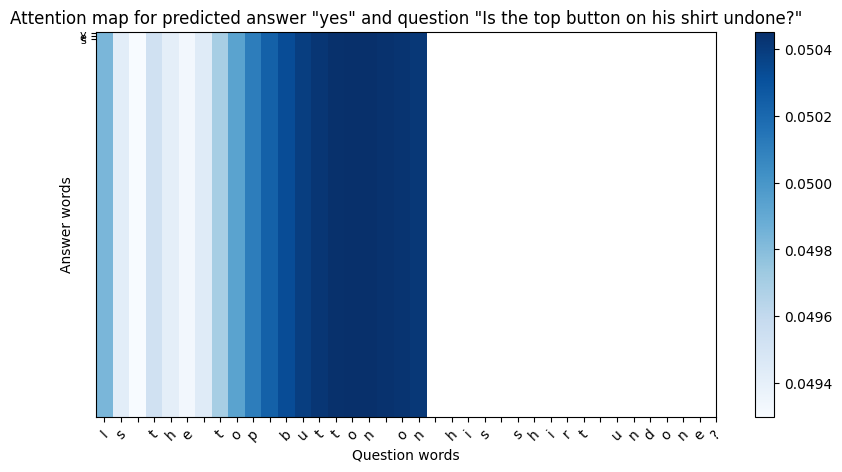

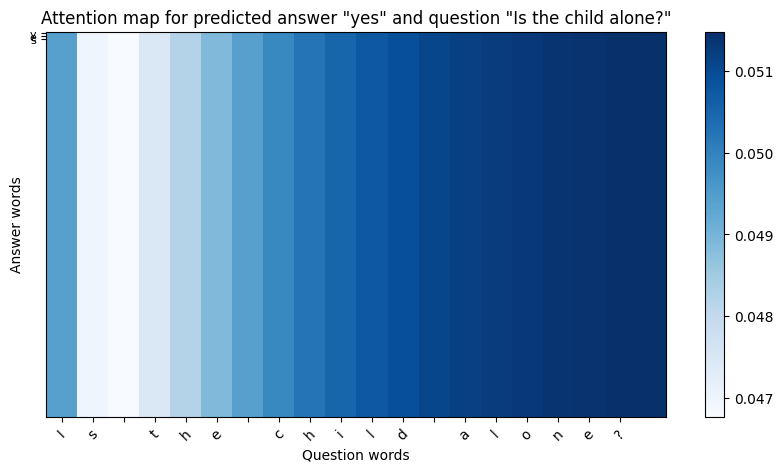

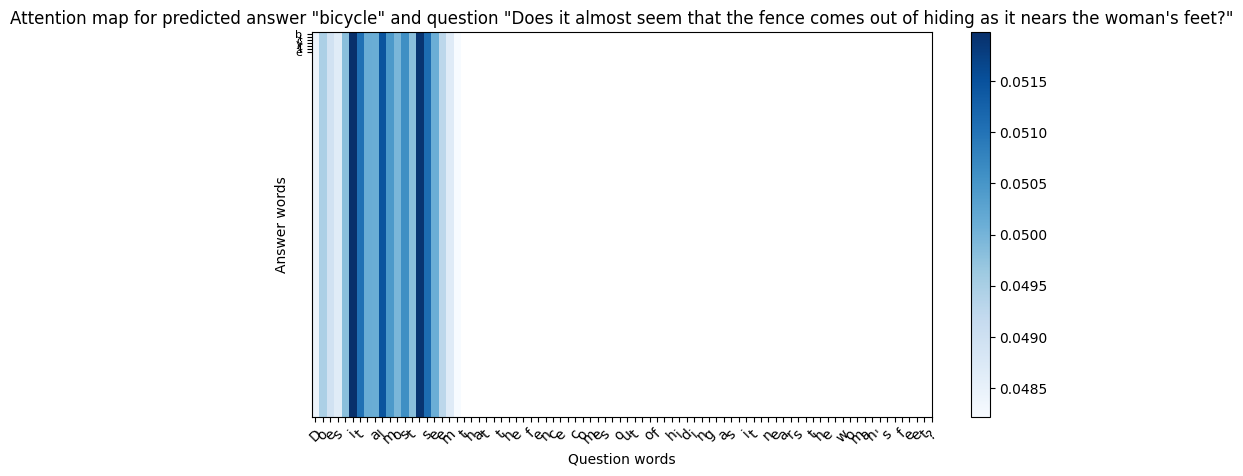

In [70]:
# GET ATTENTION MAPS BETWEEN QUESTION WORD AND PREDICTED ANSWER

question_weights = random_question_weights
question_features = random_question_features

for i in range(len(random_questions)):
    # Compute the attention weights between the answer and each question word
    
    
    ff=question_features[i].reshape(1,-1)
    gg=question_weights[i].reshape(1,-1)
    
    attention_weights = np.dot(ff.T, gg)
    attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
    
    # Plot the attention map
    plt.figure(figsize=(10, 5))
    plt.imshow(attention_weights, cmap='Blues', interpolation='nearest', aspect='auto')
    plt.xticks(np.arange(len(random_questions[i])), random_questions[i], rotation=45)
    plt.yticks(np.arange(len(predicted_answers[i])), predicted_answers[i],fontsize=8)
    plt.xlabel('Question words')
    plt.ylabel('Answer words')
    plt.title('Attention map for predicted answer "{}" and question "{}"'.format(predicted_answers[i], random_questions[i]))
    plt.colorbar()
    plt.show()

# **GET IMAGE ATTENTION MAPS...DIFFERENT TYPES**

In [71]:
import tensorflow as tf
import numpy as np
import cv2

def get_gradcam(model_of_image, input_image, class_idx):
    # Convert the image to a tensor and normalize it
    tensor_image = tf.convert_to_tensor(input_image, dtype=tf.float32)
    mean = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
    std = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)
    tensor_image = (tensor_image / 255.0 - mean) / std

    # Convert the tensor to a variable with gradient tracking enabled
    tensor_image = tf.Variable(tensor_image, trainable=True)

    # Forward pass the image through the model
    with tf.GradientTape() as tape:
        output = model_of_image(tensor_image)

    # Compute the gradient of the output with respect to the input image
    grads = tape.gradient(output, tensor_image)
    grads = tf.reduce_mean(grads, axis=(1, 2))

    # Compute the weights by averaging the gradients along the spatial dimensions
    weights = tf.reduce_mean(grads, axis=0)
    activation_map = tf.reduce_sum(tf.multiply(weights, input_image), axis=-1)

    # Apply ReLU activation to the activation map
    activation_map = np.maximum(activation_map, 0)

    # Normalize the activation map
    activation_map = cv2.normalize(activation_map, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    return activation_map


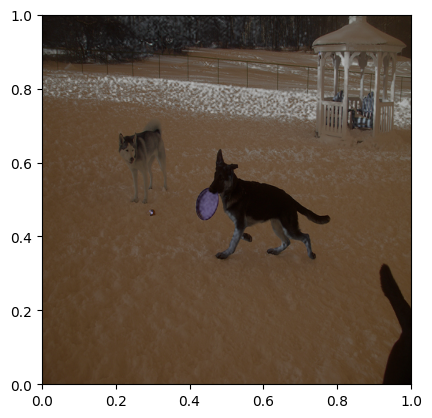

In [72]:
image = cv2.imread(random_image_paths[0])
input_image = np.array(image)
x=tf.image.resize(input_image, [224, 224]).numpy()
kk=x = np.expand_dims(x, axis=0)
kk.shape
heatmap=get_gradcam(model_of_image, kk, indexs_predicted_answers[0])
heatmap = np.concatenate([heatmap, heatmap, heatmap], axis=0)
heatmap = heatmap.transpose((1, 2, 0))
extent = 0, 1, 0, 1
plt.imshow(image, cmap='gray_r', extent=extent)
plt.imshow(heatmap, cmap='magma', vmin=0, vmax=1,extent=extent, alpha=0.5,interpolation='lanczos')

# plt.imshow(heatmap, cmap='magma')
# plt.axis('off')
plt.show()

In [124]:
question_weights = random_question_weights
question_features = random_question_features
ff=question_features[1].reshape(1,-1)
gg=question_weights[1].reshape(1,-1)
attention_weights = np.dot(ff.T, gg)
attention_weights /= attention_weights.sum(axis=-1, keepdims=True)
    
attn_image = attention_weights[0, :, :, 0]

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
    
    
ax[0].imshow(image)
ax[1].imshow(attn_image, cmap="jet")

ax[0].axis("off")
ax[1].axis("off")
plt.show()

IndexError: ignored

In [73]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt 
import matplotlib.image as imgryr

# Load the pre-trained CNN model
model = tf.keras.applications.VGG16(weights='imagenet')



In [74]:
for i in range(len(random_image_paths)):    
    img_path =random_image_paths[i]
    print("Question is ",random_questions[i])
    print("Actual answer is ",random_answers[i])
    
    print("Predicted answer is ",predicted_answers[i])
    # Load the input image
    image = cv2.imread(img_path)
    image = cv2.resize(image, (224, 224))

    # Preprocess the input image
    image = tf.keras.applications.vgg16.preprocess_input(image)

    # Extract the feature maps using the pre-trained model
    feature_maps = model.predict(np.array([image]))

    # Implement Grad-CAM to generate the heatmap
    last_conv_layer = model.get_layer('block5_conv3')
    grad_model = tf.keras.models.Model([model.inputs], [last_conv_layer.output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(np.array([image]))
        loss = predictions[:, np.argmax(predictions[0])]
    grads = tape.gradient(loss, conv_output)[0]
    guided_grads = tf.cast(conv_output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(conv_output.shape[1:3], dtype=np.float32)

    # add a new axis to weights to match the channel dimension of conv_output
    weights = tf.expand_dims(weights, axis=0)

    for i in range(conv_output.shape[-1]):
        cam += weights[0, 0, i] * conv_output[0, :, :, i]

    # Normalize the heatmap
    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = cam / np.max(cam)

    # Overlay the heatmap onto the input image
    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    print(heatmap.shape,heatmap.dtype)
    print(image.shape,image.dtype)
    image = (image * 255).astype(np.uint8)

    # normalize the heatmap to have values between 0 and 255
    heatmap_norm = cv2.normalize(heatmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    output_image = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 0.5, heatmap, 0.5, 0)

    # # Display the input image with the attention map
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [76]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

for i in range(len(random_image_paths)):    
    img_path =random_image_paths[i]
    print("Question is ",random_questions[i])
    print("Actual answer is ",random_answers[i])
    
    print("Predicted answer is ",predicted_answers[i])
    img = image.load_img(img_path, target_size=(224, 224))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    class_idx = np.argmax(preds[0])

    last_conv_layer = model.get_layer('block5_conv3')

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('block5_conv3').output, model.output])
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(x)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_output)[0]

    weights = tf.reduce_mean(grads, axis=(0, 1))

    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    heatmap_gray = np.max(heatmap, axis=-1) # convert to grayscale
    heatmap_gray = np.uint8(heatmap_gray / np.max(heatmap_gray) * 255) # normalize and convert to 8-bit
    heatmap_jet = cv2.applyColorMap(heatmap_gray, cv2.COLORMAP_MAGMA) # takes 2D array
    ad=image.img_to_array(img)
    ad = np.array(ad, dtype=np.uint8)

    superimposed_img = cv2.addWeighted(ad, 0.6, heatmap_jet, 0.4, 0)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()


Output hidden; open in https://colab.research.google.com to view.